In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.interpolate import interp1d
import scipy.optimize as op
import emcee
import corner

import time as Time
tstamp = Time.strftime("%d_%m_%Y_%H_%M", Time.localtime())

from IPython.display import display, Math

for att in ['axes.labelsize', 'axes.titlesize', 'legend.fontsize',
            'legend.fontsize', 'xtick.labelsize', 'ytick.labelsize']:
    plt.rcParams[att] = 15
    
from funcs.gj1243 import (choose_lnprob,
                          loglikelihood_full,
                          loglikelihood_fwhm,
                          loglikelihood_rise,
                          loglikelihood_decay,
                          lnprior_full,
                          lnprior_fwhm,
                          lnprior_rise,
                          lnprior_decay,
                          lnprior_rise_uniform,
                          model_rise,
                          model_decay,)

In [104]:
#tstamp = "17_03_2020_15_42"
df = pd.read_csv("../flare_tables/20200227_vetted_flares_lacking_some.csv")
df = df[df.real == 1] 
df = df[df.complex == 0]
df = df[df.ampl_rec > .01]
#df = df[(df.cstop-df.cstart) < 60]
df = df[(df.cstop-df.cstart) > 4]

885 / df.shape[0]

5.175438596491228

In [105]:
series = {}

for cond, S, color in [#((df.st == 6), "M6", "red"),
                       #((df.st == 7), "M7", "blue"),
                       #((df.st == 8), "M8", "orange"),
                       #((df.st == 9), "M9", "green"),
                       #((df.st > 6), ">M6", "grey"),
                       ((df.st>5),"all", "k")
                      ]:

    d = df[cond]
    n = d.shape[0]
    
    a = np.ones((n, 100));
    ns, ni = 100000, 0
    fig, ax = plt.subplots(1, figsize=(8,6))
    
    for i in range(n):
        l = d[["TIC","sector","cstart"]].iloc[i]
        try:
            s =f"{str(l.TIC).zfill(16)}_{l.sector}_{l.cstart}_long.csv"
            f = pd.read_csv(f"../flare_snippets/{s}")
            #f = f.iloc[90:,:]

            # Interpolation
        
            interp = interp1d(f.c, f.f, kind='linear')
            time = np.linspace(f.c.values[0], f.c.values[-1],f.shape[0]*20 ) # scale up to Davenport upsampling
            flux = (interp(time) -1.)
        except:
            print(s)
            continue
        
        # Scale to FWHM
        fwhmmin, fwhmmax = -5., 20.
        maxflux = np.max(flux)
        argmaxflux = np.argmax(flux)
        t12rise = np.argmin(np.abs(flux[:argmaxflux+1] * 2. - maxflux))  
        t12decay = np.argmin(np.abs(flux[argmaxflux:] * 2. - maxflux))
        t12 = time[argmaxflux + t12decay] - time[t12rise]
        
        timet12 = (time - time[argmaxflux]) / t12
        fluxt12 = flux / maxflux
        
        # Find good time series to reindex to
        series[i] = pd.Series(fluxt12, index=timet12)
       
        if timet12.shape[0] < ns:
            if ((timet12[0]<=fwhmmin) & (timet12[-1]>=fwhmmax)):
                ns = timet12.shape[0]
                ni = i
        # plot individual flares
       # plt.plot(timet12, fluxt12, c="c", alpha=.1)
    
    # stack an average
    df = pd.DataFrame(series)
    df = df[(df.index > fwhmmin) & (df.index < fwhmmax)]
    df2 = df.interpolate("index").reindex(index=series[ni].index.values,
                                          columns=df.columns.values)
    meanval = df2[(df2.index>-5.)].median(axis=1)
    stdval = np.sqrt(df2[(df2.index>-5.)].var(axis=1))
    time, flux, flux_err = meanval.index, meanval.values, stdval.values
    condit = np.where(np.invert(np.isnan(time)) &
                      np.invert(np.isnan(flux)) &
                      np.invert(np.isnan(flux_err)))
    time, flux, flux_err = time[condit], flux[condit], flux_err[condit]
    tfe = pd.DataFrame({"time" : time, "flux" : flux, "flux_err" : flux_err})
    tfe.to_csv(f"../analysis/{tstamp}_median_flux_{S}.csv", index=False)
    
    # Plot KDE plot
    vals = []
    for i, column in df2.iteritems():
        column = column.dropna()
        vals.append(list(zip(column.index.values, column.values)))
    vals

    from seaborn import kdeplot, cubehelix_palette
    val2 = [v for sl in vals for v in sl]
    val3 = np.array(val2).T

    valdf = pd.DataFrame({"x":val3[0], "y":val3[1]})
    cmap = cubehelix_palette(as_cmap=True, dark=1, light=0, rot=-.75, reverse=True)
    kdeplot(valdf.x, valdf.y, cmap=cmap, n_levels=60, shade=True, ax=ax);
    
#     # maximize likelihood to get init values for MCMC
#     nll = lambda *args: -loglikelihood(*args)
#     result = op.minimize(nll, [0.01,1.2,1.2], args=(time, flux, flux_err),options={ 'disp': True})
#     tpeak_ml, dur_ml, ampl_ml = result["x"]
    
#     # run MCMC
#     ndim, nwalkers = 1, 100
#     #pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
#     pos = [1. + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
#     filename = f"../mcmc/{tstamp}_uninf_prior_full_model_fwhm.h5"
#     backend = emcee.backends.HDFBackend(filename)
#     #backend.reset(nwalkers, ndim)
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_fwhm, args=(time, flux, flux_err), backend=backend)
#     sampler.run_mcmc(pos, 10, progress=True)
    #tau = sampler.get_autocorr_time()
    #print(tau)
    
    # Plot MCMC result
#    samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
#     for tpeak, dur, ampl in samples[np.random.randint(len(samples), size=50)]:
#         plt.plot(time, aflare(time, tpeak, dur, ampl), color="k", alpha=0.1)
#     plt.plot(time, aflare(time, tpeak, dur, ampl), color="k", alpha=0.1, label="MCMC fit")
    plt.xlim(-5,20)
    plt.xlabel("time [FWHM]")
    plt.ylabel("normalized flux");
    
    # plot average + std
    ax.plot(time, flux, c="r", linewidth=2, label="median flux")
    ax.plot(time, flux - flux_err, c="r", linewidth=1.5, linestyle="dashed", label=r"median flux $\pm 1\sigma$")
    ax.plot(time, flux + flux_err, c="r", linewidth=1.5, linestyle="dashed")
    
    # Finish figure
    plt.tight_layout()
    plt.savefig(f"../plots/{tstamp}_{S}_davenport_fit_median_norel_long.png", dpi=300)
    plt.close()
    
#     # Plot cornerplot
#     fig = corner.corner(samples, labels=["$tpeak$", "$dur$", "$ampl$"],)
#     plt.savefig(f"../plots/{tstamp}_{S}_davenport_fit_mcmc_corner_median_norel_long.png", dpi=300)
#     plt.close()

0000000389051009_1_81201_long.csv
0000000388857263_11_284987_long.csv
0000000332623751_5_162530_long.csv
0000000328254412_4_137225_long.csv
0000000279482950_4_134409_long.csv
0000000272349442_9_240532_long.csv
0000000272349442_9_233644_long.csv
0000000220429097_6_178611_long.csv
0000000167894019_5_168320_long.csv
0000000167894019_3_127750_long.csv
0000000142052876_3_126374_long.csv
0000000077111651_3_125489_long.csv


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [ ]:
# from IPython.display import display, Math
# flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

# with open("../tables/davenport_model.txt", "a") as f:
#         f.write(f"{tstamp} fit Davenport model to data with uniform prior.")

# labels = [r"t_\mathrm{peak}", r"\mathrm{FWHM}_r", "a_r"]
# for i in range(ndim):
#     mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
#     q = np.diff(mcmc)
#     txt1 = f"{labels[i]} = {mcmc[1]:.3f}_{{-{q[0]:.3f}}}^{{{q[1]:.3f}}}"
#     display(Math(txt1))
    
#     with open("../tables/davenport_model.txt", "a") as f:
#         f.write("$" + txt1 + "$\n")

In [78]:
ts = "17_03_2020_15_42"
tfe = pd.read_csv(f"../analysis/{ts}_median_flux_all.csv")
time, flux, flux_err = tfe.time.values, tfe.flux.values, tfe.flux_err.values

array([0.05110888, 0.04766654, 0.0456033 , 0.04548514, 0.04603944,
       0.04700672, 0.04962463, 0.05186855, 0.05113391, 0.05104836,
       0.05032806, 0.04890152, 0.04684006, 0.04473095, 0.04319623,
       0.04453775, 0.04683819, 0.0495499 , 0.04870809, 0.04754649,
       0.04726134, 0.046877  , 0.04689964, 0.04761921, 0.04814091,
       0.04742457, 0.04757855, 0.04693176, 0.0457437 , 0.04667635,
       0.04694827, 0.0468504 , 0.04809703, 0.04959452, 0.05059756,
       0.05160753, 0.05114342, 0.04995303, 0.05019324, 0.05211466,
       0.05397859, 0.05031156, 0.04779963, 0.04804645, 0.05082569,
       0.04758207, 0.04536363, 0.04465289, 0.04398481, 0.04479268,
       0.04700313, 0.05163669, 0.05736648, 0.06070805, 0.05750905,
       0.0539158 , 0.05114132, 0.04825263, 0.04667278, 0.04732954,
       0.04940575, 0.05190287, 0.05160169, 0.04900236, 0.04858822,
       0.04869884, 0.04938404, 0.05004516, 0.05149121, 0.05478592,
       0.05802128, 0.0555733 , 0.05120639, 0.04882905, 0.04821

## Fit the rise phase

In [3]:
cond = (time<=0.) & (time>=-1.)
t_rise = time[cond]
f_rise = flux[cond]
ferr_rise = flux_err[cond]


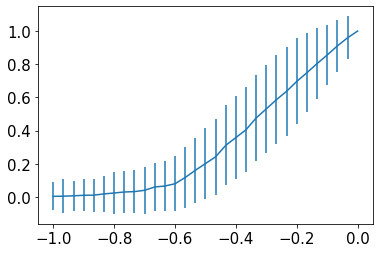

In [5]:
plt.errorbar(t_rise,f_rise,yerr=ferr_rise);

In [6]:
tstamp

'18_03_2020_11_11'

In [11]:
# MCMC

# Setup chain
ndim, nwalkers = 4, 100
truths = [1.941, -.175,  -2.246, -1.125]
e_truths = [.008, .032, .039, .016]
pos = [truths + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# choose posterior distribution function
lnprob = choose_lnprob(lnprior_rise_uniform, loglikelihood_rise)

# Save chain
#tstamp = "17_03_2020_16_05"
filename = f"../mcmc/{tstamp}_rise_phase.h5"
backend = emcee.backends.HDFBackend(filename)
#backend.reset(nwalkers, ndim)
rise_sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(t_rise, f_rise, ferr_rise), backend=backend)

# run MCMC
rise_sampler.run_mcmc(pos, 500, progress=True);

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 500/500 [01:51<00:00,  4.50it/s]


In [12]:
tau = rise_sampler.get_autocorr_time()

print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [37.52194076 37.91377198 37.76696509 37.33770151]

In [15]:
new_backend = emcee.backends.HDFBackend(filename)
print("Initial size: {0}".format(new_backend.iteration))
rise_sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(t_rise, f_rise, ferr_rise),
                                     backend=new_backend)
rise_sampler.run_mcmc(None, 3000)
print("Final size: {0}".format(new_backend.iteration))

Initial size: 1020


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Final size: 4020


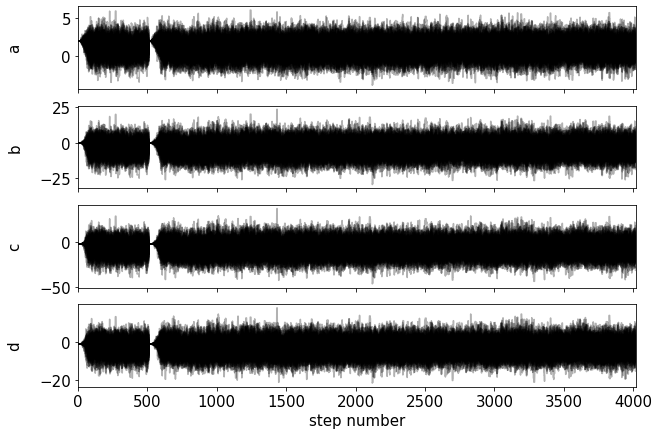

In [20]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = rise_sampler.get_chain()
labels = ["a", "b", "c", "d"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

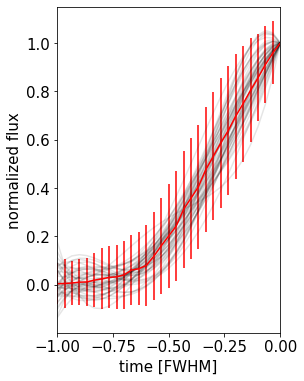

In [16]:
# Plot MCMC result
plt.figure(figsize=(4,6))
rise_samples = rise_sampler.chain[:, 50:, :].reshape((-1, ndim))
for a,b,c,d in rise_samples[np.random.randint(len(rise_samples), size=50)]:
    plt.plot(t_rise, model_rise(a, b, c, d, t_rise), color="k", alpha=0.1)
plt.errorbar(t_rise, f_rise, yerr=ferr_rise, c="r")
plt.xlim(-1,0)
plt.xlabel("time [FWHM]")
plt.ylabel("normalized flux");
#plt.savefig(f"../plots/{tstamp}_rise_phase_sampling.png", dpi=300)

In [21]:
tau = rise_sampler.get_autocorr_time()
print(tau)
flat_samples = rise_sampler.get_chain(discard=100, thin=15, flat=True)

[42.60372309 42.39321655 42.2474206  42.21777596]


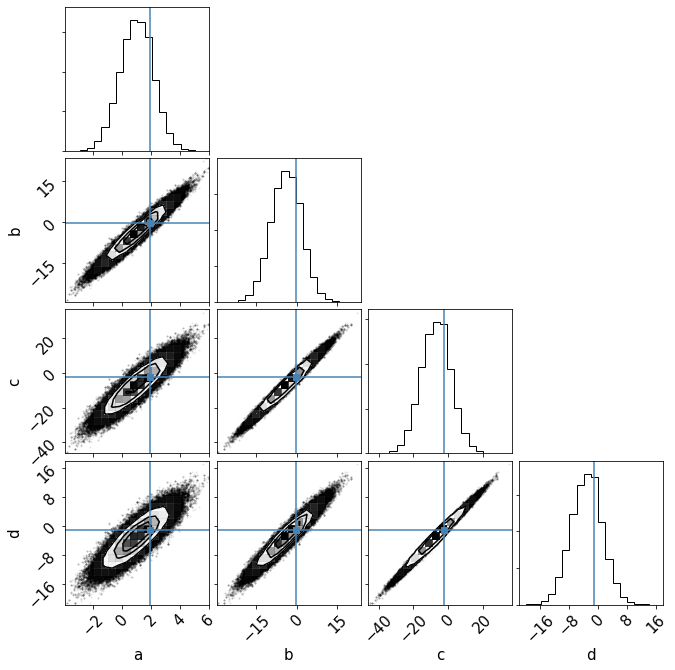

In [22]:
# Plot cornerplot
fig = corner.corner(rise_samples, labels=["a","b","c","d"], truths=truths)
#plt.savefig(f"../plots/{tstamp}_rise_phase_sampling_corner.png", dpi=300);

In [23]:
flat_samples = rise_sampler.get_chain(discard=100, thin=15, flat=True)


with open("../tables/davenport_model.txt", "a") as f:
    f.write(f"\n{tstamp} fit Davenport rise model to data with uniform prior.\n")

labels = [r"a", r"b", r"c", r"d"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt1 = f"{labels[i]} = {mcmc[1]:.3f}_{{-{q[0]:.3f}}}^{{{q[1]:.3f}}}"
    #txt1 = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt1))
    txt2 = f"{labels[i]} = {truths[i]:.3f}_{{-{e_truths[i]:.3f}}}^{{{e_truths[i]:.3f}}}"
    display(Math(txt2))
    
    with open("../tables/davenport_model.txt", "a") as f:
        f.write("TESS: $" + txt1 + "$\n")
        f.write("Kepler: $" + txt2 + "$\n")
    

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Decay phase fit

In [24]:
#tstamp = "17_03_2020_15_42"
truths = [0.6890, -1.600, 0.3030, -0.2783] #a,b,c,d
e_truths = [0.0008, 0.003, 0.0009, 0.0007]
tstamp

'18_03_2020_11_11'

In [25]:
cond = (time>=0.) & (time<20.)
t_decay = time[cond]
f_decay = flux[cond]
ferr_decay = flux_err[cond]

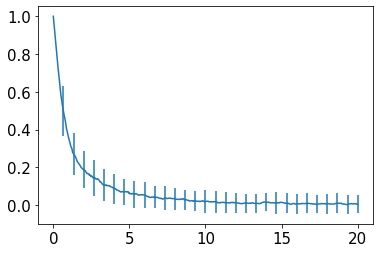

In [26]:
plt.errorbar(x=t_decay, y=f_decay, yerr=ferr_decay, errorevery=20);

In [28]:
# run MCMC
ndim, nwalkers = 4, 100
lnprob = choose_lnprob(lnprior_rise_uniform, loglikelihood_decay)
pos = [truths + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

filename = f"../mcmc/{tstamp}_decay_phase_uniform.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
decay_sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(t_decay, f_decay, ferr_decay), backend=backend)

decay_sampler.run_mcmc(pos, 1000, progress=True);

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 1000/1000 [03:07<00:00,  5.34it/s]


In [32]:
new_backend = emcee.backends.HDFBackend(filename)
print("Initial size: {0}".format(new_backend.iteration))
decay_sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(t_decay, f_decay, ferr_decay),
                                      backend=new_backend)
decay_sampler.run_mcmc(None, 500)
print("Final size: {0}".format(new_backend.iteration))

Initial size: 2000
Final size: 2500


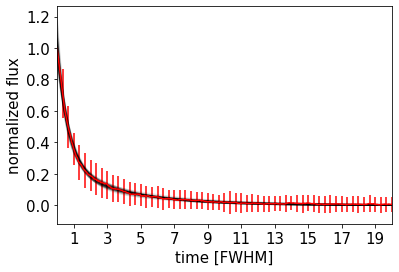

In [34]:
# Plot MCMC result
decay_samples = decay_sampler.chain[:, 50:, :].reshape((-1, ndim))
for a,b,c,d in decay_samples[np.random.randint(len(decay_samples), size=50)]:
    plt.plot(t_decay, model_decay(a,b,c,d,t_decay), color="k", alpha=0.1)
plt.errorbar(t_decay,f_decay,yerr=ferr_decay, c="r", errorevery=10)
plt.xlim(0.,20)
plt.xlabel("time [FWHM]")
plt.ylabel("normalized flux")
plt.xticks(np.arange(1,20,2))
plt.savefig(f"../plots/{tstamp}_decay_phase_sampling_uniform.png", dpi=300)

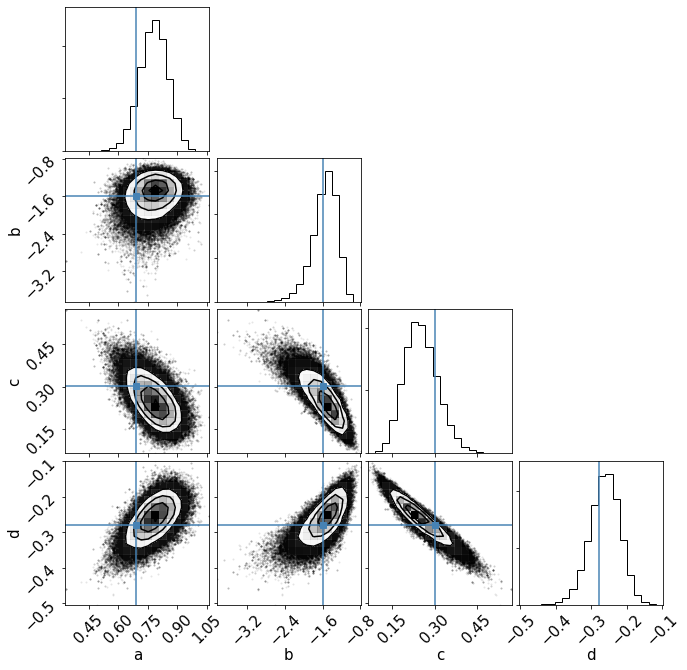

In [35]:
# Plot cornerplot
fig = corner.corner(decay_samples, labels=["a","b","c","d"], truths=truths)
plt.xticks
plt.savefig(f"../plots/{tstamp}_decay_phase_sampling_corner_uniform.png", dpi=300);

In [33]:
tau = decay_sampler.get_autocorr_time()
print(tau)

[42.78729976 43.20667694 45.7380056  45.80078264]


In [37]:
flat_samples = decay_sampler.get_chain(discard=100, thin=15, flat=True)



with open("../tables/davenport_model.txt", "a") as f:
    f.write(f"{tstamp} fit Davenport decay model to data with uniform prior.\n")

labels = [r"a", r"b", r"c", r"d"]
res = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    res.append(mcmc[1])
    q = np.diff(mcmc)
    txt1 = f"{labels[i]} = {mcmc[1]:.3f}_{{-{q[0]:.3f}}}^{{{q[1]:.3f}}}"
    #txt1 = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt1))
    txt2 = f"{labels[i]} = {truths[i]:.3f}_{{-{e_truths[i]:.3f}}}^{{{e_truths[i]:.3f}}}"
    display(Math(txt2))
    with open("../tables/davenport_model.txt", "a") as f:
        f.write("TESS: $" + txt1 + "$\n")
        f.write("Kepler: $" + txt2 + "$\n")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [67]:
t_decay

150     0.000000
151     0.033333
152     0.066667
153     0.100000
154     0.133333
         ...    
746    19.866667
747    19.900000
748    19.933333
749    19.966667
750    20.000000
Name: time, Length: 601, dtype: float64

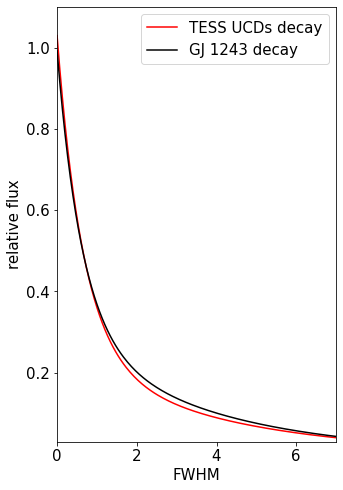

In [80]:
plt.figure(figsize=(5,8))
plt.plot(t_decay, model_decay(*res,t_decay),#/model_decay(*res,t_decay.values[0]),
         color="r", label="TESS UCDs decay")
plt.plot(t_decay, model_decay(*truths,t_decay),#/model_decay(*truths,t_decay.values[0]),
         color="k", label="GJ 1243 decay");
plt.xlim(0,7.)
#plt.yscale("log")
plt.xlabel("FWHM")
plt.ylabel("relative flux")
plt.ylim(3e-2,1.1)
plt.legend();

# Plot rise and decay phase together

In [ ]:
# Plot MCMC result
rise_samples = rise_sampler.chain[:, 50:, :].reshape((-1, ndim))
decay_samples = decay_sampler.chain[:, 50:, :].reshape((-1, ndim))

plt.figure(figsize=(8,6))
for a,b,c,d in decay_samples[np.random.randint(len(decay_samples), size=50)]:
    plt.plot(t_decay, model_decay(a,b,c,d,t_decay), color="k", alpha=0.1)
plt.errorbar(t_decay,f_decay,yerr=ferr_decay, c="r", errorevery=10)
for a,b,c,d in rise_samples[np.random.randint(len(rise_samples), size=50)]:
    plt.plot(t_rise, model_rise(a,b,c,d,t_rise), color="k", alpha=0.1)
plt.errorbar(t_rise,f_rise,yerr=ferr_rise, c="r", errorevery=5)
plt.axvline(0)
plt.xlim(-1.,7.)
plt.xlabel("time [FWHM]")
plt.ylabel("normalized flux")
plt.xticks(np.arange(-1,7,1))
plt.yscale("log")
plt.ylim(1e-2,1.1)
plt.savefig(f"../plots/{tstamp}_both_phases_sampling.png", dpi=300)